# Image Compression using K-Means clustering

One of the cool things that we can do using K-means clustering algorithm is that we can use it to compress images. In this question of your test you will be implementing K-means clustering algorithm and then apply it on a RGB image to compress it. Note: We will be operating with PNG images and the technique mentioned in this notebook is only applicable for PNG images

## How it works
Before we understand the compression algorithm lets first see how PNG images are represented in memory. Unlike in a jpg image where for each pixel in the image 24 bits are stored (8 bits for each color RGB to store the intensity value), in png image we have a color palette of different colors present in the image and each pixel in the image stores the value of the index of the color in the color palettes. 
You can think of color palettes as an array of different colors, where each color is a 24 bit value. The following image demonstrates this idea well:

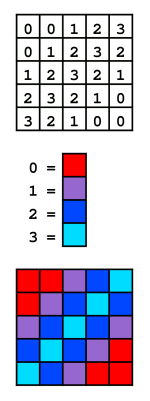

For eg: if we have 8 different colors in the pallet the value of indices will range from 0 to 7 which will take 3 bits to store for each location. Similarly if we have 16 different colors in the pallet the indices will range from 0 to 15 which will take 4 bits to represent. In general for k colors in the pallet we need $\log_{2}k$ bits for representing every element of the 2d array.

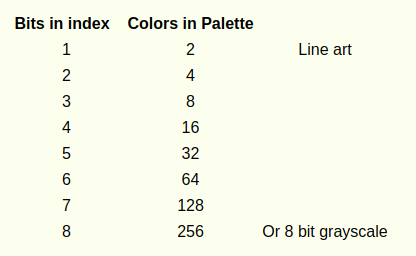

Hence decreasing the number of colors in the pallet decreases the number of bits required for each pixel, thereby decreasing the memory taken by the image. This is where K-means clustering comes into the picture. We will group the colors in the image into some fixed number of clusters and then replace all the colors with the centroid of the cluster they belong to. This will reduce the number of colors in the palette thereby compressing the image. **In short we can say that the number of colors in the color palette of the compressed image will be equal to the number of clusters**.

However when we open an image in python, it is represented as 3 dimensional arrays which can be thought of as 3 matrices stacked together with each matrix storing the intensity of red,blue and green colors repectively for all rows and columns in the image. The color intensites are obtained from the palette only. The following figure demonstrates the stated fact.

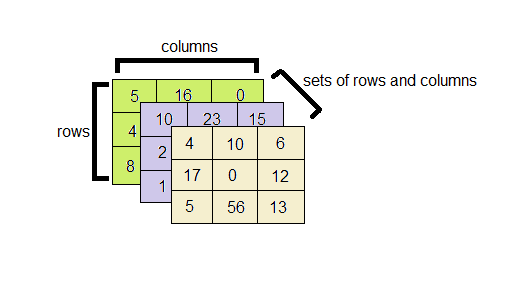

Now what we do is that we first reshape the image into a 2d array or matrix such that number of rows becomes the width*height of the image and the number of columns are 3 (for each color RGB). Hence each row of our resulting array will contain pixel wise information of the image. For eg: a 32x32x3 image (32,32 corresponds to width and height, and 3 corresponds to the RGB channels) will be reshaped into a 1024x3 matrix. 

After we have reshaped our image we apply standard k means to the resulting matrix. It will work as follows each pixel will act as a data point and each data point will have 3 features for intensity of red, blue and green colors. Using k means we will group all these data points into some fixed number of clusters eg 16 or 32. Finally for each pixel in the image we will store the value of the centroid to which the pixel belongs to. Hence our final image will contain only fixed number of distinct (equal to the number of clusters) rgb values. Your final results should look like following:

<h2><center>Original Image</center></h2>

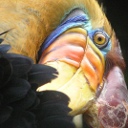

<h2><center>Compressed Image</center></h2>

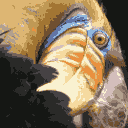


## Graded Components
You will be implementing the following functions in this notebook
-  **flatten_image(image)** 0.5 Marks
-  **get_size_of_png_img(width, height, k)** 1 Mark
-  **get_compression_ratio(width, height, imsize, k)** 0.5 Marks
-  **choose_centroids_at_random(data, num_centroids)** 1 Mark
-  **get_closest_centroids(data, centroids)** 1 Mark
-  **update_centroids(data, centroids, K)** 1 Mark
-  **eval_objective_function(data, centroids)** 1 Marks
-  **kmeans(image, num_centroids, max_iter)** 2 Marks
-  **get_cmp_img(labels, centroids, rows, cols)** 2 Marks

**Super Important: Whenever required to return an array in any function make sure its a numpy array. To convert a python list to a numpy array, use np.array(A) where A is a python list**

In [ ]:
#Importing all the necessary packages. Don't import any additional packages
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import os
from math import log,ceil

In [ ]:
                            """Don't change code in this cell"""

#Reading the image into the memory using skimage package
#You dont need to worry about how skimage works, just remember when we read an image using skimage it is stored as a numpy array
image = io.imread("bird_small.png")
height, width, _ = image.shape
imsize = os.stat("bird_small.png").st_size
io.imshow(image)
io.show()

## TASK 1

Implement the **flatten_image** function. It takes the image, then reshapes it into a 2 dimensional array. If the image is of shape [rows,cols,3] it is to be reshaped into a 2 dimensional array [rows*cols,3]. In the following figure we have a 3x3x3 image which is reshaped into a 9x3 array
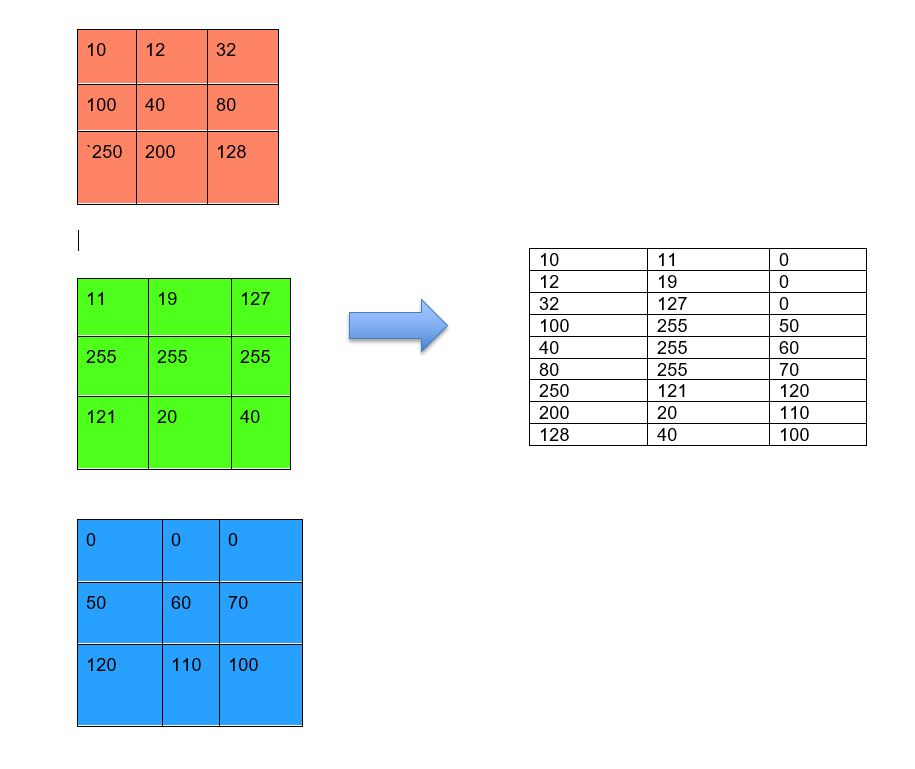




In [ ]:
#Graded function 1:

def flatten_image(image):
    '''
    Reshapes the image which is a 3 dimensional array to a 2 dimensional array
    
    Inputs:
    - image: A 3 dimensional numpy array of shape [height,width,3]
    Returns:
    A 2 dimensional array of shape [height*width,3]
    '''
    # YOUR CODE HERE
    raise NotImplementedError()
    return flat_img

In [ ]:
                            """Don't change code in this cell"""
#SAMPLE TEST CASE
print("Running Sample Test Case")
np.random.seed(seed=0)
img = np.random.randn(4, 4, 3)
img_flat = flatten_image(img)
answer = np.array([[ 1.76405235,  0.40015721,  0.97873798],
       [ 2.2408932 ,  1.86755799, -0.97727788],
       [ 0.95008842, -0.15135721, -0.10321885],
       [ 0.4105985 ,  0.14404357,  1.45427351],
       [ 0.76103773,  0.12167502,  0.44386323],
       [ 0.33367433,  1.49407907, -0.20515826],
       [ 0.3130677 , -0.85409574, -2.55298982],
       [ 0.6536186 ,  0.8644362 , -0.74216502],
       [ 2.26975462, -1.45436567,  0.04575852],
       [-0.18718385,  1.53277921,  1.46935877],
       [ 0.15494743,  0.37816252, -0.88778575],
       [-1.98079647, -0.34791215,  0.15634897],
       [ 1.23029068,  1.20237985, -0.38732682],
       [-0.30230275, -1.04855297, -1.42001794],
       [-1.70627019,  1.9507754 , -0.50965218],
       [-0.4380743 , -1.25279536,  0.77749036]])
assert np.allclose(img_flat, answer, rtol=1e-05, atol=1e-06)
print("Sample Test Case Passed")

In [ ]:
                            """Don't change code in this cell"""

#Hidden Test cases


## TASK 2

Implement get_size_of_png_img and get_compression_ratio functions.
The size of a png image can be approximated by the following formula:

\begin{align}
s: Size \ of \ image \ in \ bytes\\
w: width \ of \ image \\
h: height \ of \ image \\
b: number \ of \ bytes \ required \ to \ represent \ indices \\
k: number \ of \ colors \ in \ the \ palleat \\
\\
s = w*h*b/8 + 24*k \\
\\
b = ceil(log_{2}(k)) \\
\end{align}

*Hint*: log and ceil functions might be helpful. First argument of log function takes the number whose log is to be calculated as input and second argument refers to the base of the log function.

Finally the compression ratio is calculated as the ratio of the size of original image and the size of compressed image. The value of original image is already calculated in the second cell of the notebook, and the size of compressed image can be calculated using get_size_of_png_img function given the number of pellets in the compressed image.

\begin{align}
A : Original \ Image \ Size \\
B: Compressed \ Image \ Size \\
c: Compression \ Ratio \\
c = A/B \\
\end{align}


In [ ]:
#Graded function 2

def get_size_of_png_img(width, height, k):
    
    '''
    A function which calculates the size of a png image given its width, height and the number of colors in the palette.
    
    Inputs:
    -width: width of the image
    -height: height of the image
    -k: number of colors in the color palette
    
    Output:
    -size: size in bytes of the image
        
    '''
    # YOUR CODE HERE
    raise NotImplementedError()
    return size

In [ ]:
                            """Don't change code in this cell"""

#Sample Test Case
print("Running Sample Test Case")
size = get_size_of_png_img(width, height, 16)
answer = 8576
assert np.allclose(size, answer, rtol=1e-05, atol=1e-06)
print("Sample Test Case Passed")

In [ ]:
                            """Don't change code in this cell"""

#Hidden Test cases


In [ ]:
#Graded function 3

def get_compression_ratio(width, height, imsize, k):
    
    '''
    A function which given the size of original image and the information of compressed image calculates the compression ratio.
    
    Inputs:
    -width: width of the image
    -height: height of the image
    -imsize: size in bytes of the original image
    -k: number of colors in the color palette of compressed image
    
    Output:
    -cmp_ratio: The compression ratio
    
    '''
    # YOUR CODE HERE
    raise NotImplementedError()
    return cr

In [ ]:
                            """Don't change code in this cell"""

#Sample Test Case
print("Running Sample Test Case")
cmp_ratio = get_compression_ratio(width, height, imsize, 16)
answer = 3.8515625
assert np.allclose(cmp_ratio, answer, rtol=1e-05, atol=1e-06)
print("Sample Test Case Passed")

In [ ]:
                            """Don't change code in this cell"""

#Hidden Test cases


## TASK 3
Complete the function choose_centroids_at_random which takes the data and number of centroids as arguments and randomly selects centroids from the data.

In [ ]:
#Graded function 4

def choose_centroids_at_random(data, num_centroids):
    '''
    Chooses k centroids from the data randomly. Hint: np.random.choice, np.random.shuffle, np.arange might be useful
    
    Inputs:
    - data: A 2 dimensional data matrix of shape [m,n] for our purpose m will always be row*col and n will always be 3
    - num_centroids: k, basically number of centroids to randomly select from the data
    
    Returns:
    - centroids: num_centroids randomly selected from data. Shape will be [num_centroids,n]. Make sure centroids is a numpy array
    '''
    # YOUR CODE HERE
    raise NotImplementedError()
    return centroids

In [ ]:
                            """Don't change code in this cell"""

#SAMPLE TEST CASE
print("Running Sample Test Case")
np.random.seed(seed=0)
data = np.random.randn(100, 3)
centroids = choose_centroids_at_random(data, 3)
answer = np.array([[-0.67433266,  0.03183056, -0.63584608],
       [-0.17992484, -1.07075262,  1.05445173],
       [-0.18718385,  1.53277921,  1.46935877]])
assert np.allclose(centroids, answer, rtol=1e-05, atol=1e-06)
print("Sample Test Case Passed")

In [ ]:
                            """Don't change code in this cell"""
#Hidden Test cases


In [ ]:
                            """Don't change code in this cell"""

def find_dists(data, centroids):
    '''
    Computes the distance of each data point from each one of the centroids.
    Remember L2 (euclidean distance) is to be calculated
    
    Inputs:
    - data: Data matrix with shape [m,n]
    - centroids: A matrix containing k different centroids. Shape [k,n]
    
    Output:
        - dists: A matrix of shape [k,m] such that each column contains the distance of each datapoint from all the centroids
    '''
    dists = np.sqrt(np.sum((data - centroids[:, None]) ** 2, axis = 2))
    return dists

## TASK 4

Complete the function get_closest_centroids and update_centroids. get_closest_centroid function calculates the nearest centroid to each data point and returns an array containing the index of the centroid nearest to each of the data point. update_centroids function groups the data into clusters and computes the new centroids as it is done in standard K-means algorithm.

In [ ]:
# Graded function 5

def get_closest_centroids(data, centroids):
    
    '''
    Chooses the closest centroid for all the data points.
    This function first calls the find_dists function and then uses the distances to compute closest centroids
    
    Inputs:
    - data: Data matrix with shape [m,n]
    - centroids: A matrix containing k different centroids. Shape [k,n]
    
    Output:
        - closest_centroids: A [m,] numpy array such that each element consists of the index of the closest centroid
            make sure closest_centroids is a numpy array
    '''
    # YOUR CODE HERE
    raise NotImplementedError()
    return closest_centroids

In [ ]:
                            """Don't change code in this cell"""

#SAMPLE TEST CASE
print("Running Sample Test Case")
np.random.seed(seed=0)
data = np.random.randn(10, 3)
centroids = data[0:3, :]
closest = get_closest_centroids(data, centroids)
answer = ([0, 1, 2, 0, 2, 2, 2, 2, 2, 0])
assert np.allclose(closest, answer, rtol=1e-05, atol=1e-06)
print("Sample Test Case Passed")

In [ ]:
                            """Don't change code in this cell"""

#Hidden Test Case


In [ ]:
# Graded function 6

def update_centroids(data,centroids,K):
    '''
    Computes the closest centroids to each data point, to form clusters and finally
    computes the new centroids of these clusters
    
    Inputs:
    - data: Data matrix with shape [m,n]
    - centroids: A matrix containing k different centroids. Shape [k,n]
    - K: number of centroids (or clusters)
    
    Output:
        - new_centroids: A [K,n] numpy array such that each element consists of the index of the closest centroid
          make sure new_centroids is a numpy array
        
    '''
    # YOUR CODE HERE
    raise NotImplementedError()
    return new_centroids

In [ ]:
                            """Don't change code in this cell"""

#Sample Test Case
print("Running Sample Test Case")
np.random.seed(seed=0)
data = np.random.randn(10, 3)
centroids = data[0:3, :]
new_centroids = update_centroids(data, centroids, 3)
answer = np.array([[ 0.662489,   0.69232666,  1.30079009],
                    [ 2.2408932,   1.86755799, -0.97727788],
                    [ 0.8802069,   0.00339528, -0.51898503]])
assert np.allclose(new_centroids, answer, rtol=1e-05, atol=1e-06)
print("Sample Test Case passed")

In [ ]:
                            """Don't change code in this cell"""

#Hidden Test Case


## TASK 5

Complete eval_objective_function function. This function evaluates the value of the objective function of K-means clustering given the data matrix and the centroids of k clusters. The objective function of k-means is given by: $$J = \dfrac {\sum_{C(j)=i} \|X_j-X_i\|_2^2}{m}$$

where $X_j$ denotes a data point belonging to cluster $i$. Conceptually it means that we calculate the euclidean distance for all the data points to the centroid of the cluster they belong to and take the mean value for all the data points. The value of this function should reduce with the iterations of k-means.


In [ ]:
# Graded function 7
def eval_objective_function(data, centroids):
    
    '''
    Computes the k means objective function for given data and current centroids
    
    Inputs:
    - data: Data matrix with shape [m,n]
    - centroids: A matrix containing k different centroids. Shape [k,n]
    
    Output:
    obj: Value of objective function
    
    '''
    # YOUR CODE HERE
    raise NotImplementedError()
    return obj

In [ ]:
                            """Don't change code in this cell"""
#Sample Test Case
print("Running Sample Test Case")
np.random.seed(seed=0)
data = np.random.randn(10, 3)
centroids = data[0:3, :]
obj = eval_objective_function(data, centroids)
answer = 2.285237532662665
assert np.allclose(obj, answer, rtol=1e-05, atol=1e-06)
print("Sample Test Case passed")

In [ ]:
                            """Don't change code in this cell"""
#Hidden Test Case


## TASK 6

Complete the kmeans function. This function takes the image as input and runs kmeans algorithm on the image to compress it. The standard K-means Algorithm is as follows:

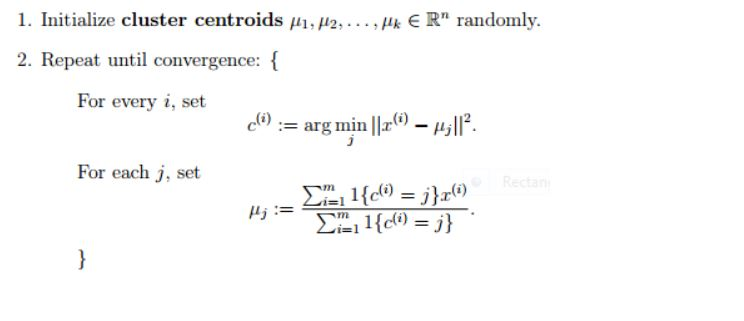

The function should return the following:

- final centroids
- labels, which is an array containing the index of the centroid of the cluster to which each data point belongs
- the value of objective function for the final value of centroids.

The termination condition of the clustering is that either the maximum number of iterations are reached or the absolute difference between the values of centroids of 2 consecutive iterations is less than the given threshold value. Mathematically it can be represented as:

$$ C_i : Previous Centroids\in \mathcal{R}^N$$

$$ C_n : New Centroids\in \mathcal{R}^N$$

$$ T : Threshold Value$$

$$ Termination Condition: max_{k}(|C_i^k - C_j^k|) < T$$

In [ ]:
#Graded function 7

def kmeans(image, num_centroids, threshold = 0.001, max_iter = 200):
    
    '''
    Runs k-means on a image
    
    Inputs:
    - image: A [height,width,3] array
    - num_centroids: number of centroids or clusters
    - threshold: Minimum difference between previous and new computed centroids
    - max_iter: maximum iterations of kmeans to perform
    
    Outputs:
    - centroids: The final computed centroids having shape [num_centroids,3]
      make sure centroids is a numpy array  
    - labels: A [height*width,] numpy array containing the index of the cluster to which a particular data point belongs to.
      Hint: get_closest function might be useful in computing labels
      make sure labels is a numpy array  
    - obj: The value of objective function of kmeans for the final clusters
    
    Sample code:
    initial_centroids = #Implement this to choose the initial value of centroids
    for itr in range(max_iter):
        #update centroids
        if(termination condition):
            break
            Do implement this carefully as mentioned in description. Note that the maximum element of the absolute difference
            should be less than the threshold value. You might find some of these useful: np.abs, np.max, np.min, np.maximum.
    labels = #Implement this to get labels for each data point
    obj = #Implement this to get the final value of centroids
            
    '''
    # YOUR CODE HERE
    raise NotImplementedError()
    return labels,centroids,obj

In [ ]:
                            """Don't change code in this cell"""
#Sample Test Case
print("Running Sample Test Case")
np.random.seed(0)
labels, centroids, obj = kmeans(image, 16)
answer = 467.18511556184023
assert np.allclose(obj, answer, rtol=1e-05, atol=1e-06)
print("Sample Test Case Passed")

In [ ]:
                            """Don't change code in this cell"""
# Hidden Test Case 1


In [ ]:
                            """Don't change code in this cell"""
# Hidden Test Case 2


## FINAL TASK

Now that we have implemented the k-means algorithm successfully we can use the centroids and labels obtained to get the compressed image. Iterate over each data point and store its corresponding centroid value (of the cluster to which that point belongs to) in a new array. Finally reshape the resulting array into image shape i.e [height,width,3].

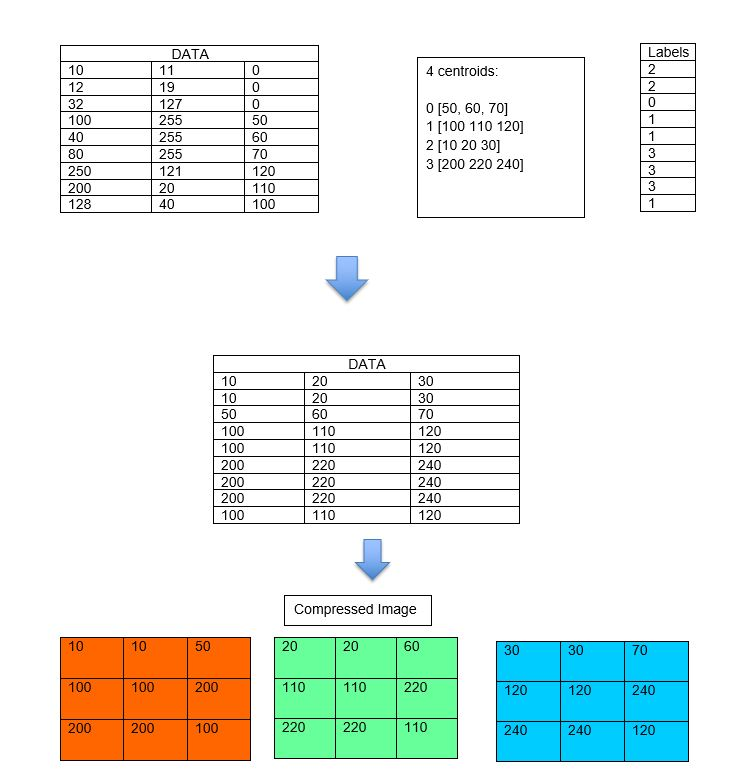

Pseudo code:
- Initialize an array of shape [width*height,3], cmp_img
- iterate for i = 0 to number of data points
    - set cmp_img[i] to the centroid of the cluster to which the data point belongs using labels.
- Reshape cmp_img into image shape

In [ ]:
# Graded function 8

def get_cmp_img(data, labels, centroids, width, height):
    '''
    Using the labels and centroids obtained from the k-means, this function forms the compressed image
    such that each pixel is replaced with its corresponding centroid value.
    
    Inputs:
    - data: Data matrix with shape [width * height, 3]
    - labels: A [width * height,] array containing the index of the centroid of the cluster to which a particular point
                belongs to
    - centroids: Final centroids computed from k-means. Shape [k, 3]
    - rows: number of rows in image
    - cols: number of columns in image
    
    Outputs:
    - cmp_img: Compressed Image of shape [height, width, 3]
    
    '''
    # YOUR CODE HERE
    raise NotImplementedError()
    cmp_img = np.array(cmp_img, dtype=np.uint8) #Do not remove this
    return cmp_img

In [ ]:
                            """Don't change code in this cell"""
#Sample Test Case
np.random.seed(0)
print("Running Sample Test Case")
image = io.imread("bird_small.png")
data = np.reshape(image, [-1, 3])
height, width, _ = image.shape
labels, centroids, obj = kmeans(image, 16)
cmp_img = get_cmp_img(data, labels, centroids, width, height)
answer = io.imread('cmp.png')
assert np.allclose(cmp_img, answer, rtol=1e-05, atol=1e-06)
io.imshow(cmp_img)
io.show()
print("Sample Test Case Passed")

In [ ]:
                            """Don't change code in this cell"""
# Hidden Test Case 1


In [ ]:
                            """Don't change code in this cell"""
# Hidden Test Case 2
